In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import lisaorbits
import h5py
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML, Image

In [2]:
rc('animation', html='html5')

In [3]:
duration = 31536000                               # a year in seconds
size = 1000                                       # number of elements
t_vec = np.linspace(0, duration, size)            # time vector
#time_origin = datetime.datetime(2034, 1, 1, 0, 0) # approximate start of LISA mission
orbits = lisaorbits.KeplerianOrbits(size = size, dt = int(duration/size))
file = "LISA_KEPLER_ORBIT_1YR_SIZE1e3.h5"
#orbits.write("LISA_KEPLER_ORBIT_1YR_SIZE1e3.h5")

In [4]:
sc_vec = ['1', '2', '3']     # spacecraft number
dimensions = ['x', 'y', 'z'] # spacecraft axes
dyn = ['x', 'v', 'a']        # position, velocity, acceleration
size = 1000                  # initialize number of elements 

dynamics = {}                # construct dictionary to store all values

# simple for loop to place sc dynamics vectors into dictionary
for i, dyn in enumerate(dyn):
    for j, scvec in enumerate(sc_vec):
        for k, dim in enumerate(dimensions):
            with h5py.File(f'./{file}', 'r') as f:
                # barycentric coordinate time
                # convert from distance units from km to m
                # [number of elements, sc#, spacecraft axis]
                dynamics[f'{scvec}_{dim}_{dyn}'] = f[f'/tcb/{dyn}'][:, j, k]/1000 

In [5]:
def RotationMatrices(angle, dimension):
    if dimension == 'z':
        rot = np.array([[np.cos(angle), -np.sin(angle), 0], 
                       [np.sin(angle),  np.cos(angle), 0], 
                       [            0,              0, 1]])

    elif dimension == 'y':
        rot = np.array([[ np.cos(angle), 0, np.sin(angle)], 
                       [             0, 1,             0], 
                       [-np.sin(angle), 0, np.cos(angle)]])

    elif dimension == 'x':
        rot = np.array([[ 1,             0,              0], 
                       [ 0, np.cos(angle), -np.sin(angle)], 
                       [ 0, np.sin(angle),  np.cos(angle)]])
    return rot

In [6]:
alpha1 =  30 * np.pi/180
alpha2 = -30 * np.pi/180

rot_laser1 = RotationMatrices(alpha1, 'z')
rot_laser2 = RotationMatrices(alpha2, 'z')
rot_laser1, rot_laser2

sc1_resultant_vector = np.row_stack((dynamics['1_x_x'], dynamics['1_y_x'], dynamics['1_z_x']))
l1_vector, l2_vector = np.zeros_like(sc1_resultant_vector), np.zeros_like(sc1_resultant_vector)

for ind in range(size):
    # we just need the unit vectors (or direction)
    l1_vector[:, ind] = (rot_laser1@sc1_resultant_vector[:, ind])
    l2_vector[:, ind] = (rot_laser2@sc1_resultant_vector[:, ind])

# we just need the directions of the lasers originating from the mosas
# so that we can maintain the known orientation of the spacecraft



In [7]:
# %matplotlib inline
# plt.figure();
# plt.scatter(t_vec, dynamics['1_x_x']);
# plt.scatter(t_vec, l1_vector[0, :]);
# plt.scatter(t_vec, l2_vector[0, :]);

# plt.figure();
# plt.scatter(t_vec, dynamics['1_y_x']);
# plt.scatter(t_vec, l1_vector[1, :]);
# plt.scatter(t_vec, l2_vector[1, :]);

# plt.figure();
# plt.scatter(t_vec, dynamics['1_z_x']);
# plt.scatter(t_vec, l1_vector[2, :]);
# plt.scatter(t_vec, l2_vector[2, :]);

# plt.figure();
# plt.scatter(dynamics['1_x_x'], dynamics['1_y_x']);
# plt.scatter(l1_vector[0, :], l1_vector[1, :], linewidths=1);
# plt.scatter(l2_vector[0, :], l2_vector[1, :], linewidths=1);

# plt.figure();
# plt.scatter(dynamics['1_x_x'], dynamics['1_z_x']);
# plt.scatter(l1_vector[0, :], l1_vector[2, :], linewidths=1);
# plt.scatter(l2_vector[0, :], l2_vector[2, :], linewidths=1);

# plt.figure();
# plt.scatter(dynamics['1_y_x'], dynamics['1_z_x']);
# plt.scatter(l1_vector[1, :], l1_vector[2, :], linewidths=1);
# plt.scatter(l2_vector[1, :], l2_vector[2, :], linewidths=1);

# ax = plt.figure(figsize=(12, 8), dpi=80).add_subplot(projection='3d')

# ax.plot(dynamics['1_x_x'], dynamics['1_y_x'], dynamics['1_z_x'], label='sc1');
# ax.plot(l1_vector[0, :], l1_vector[1, :], l1_vector[2, :], label='sc1');
# ax.plot(l2_vector[0, :], l2_vector[1, :], l2_vector[2, :], label='sc1');
# ax.plot(dynamics['2_x_x'], dynamics['2_y_x'], dynamics['2_z_x'], label='sc2');
# ax.plot(dynamics['3_x_x'], dynamics['3_y_x'], dynamics['3_z_x'], label='sc3');
# plt.legend();


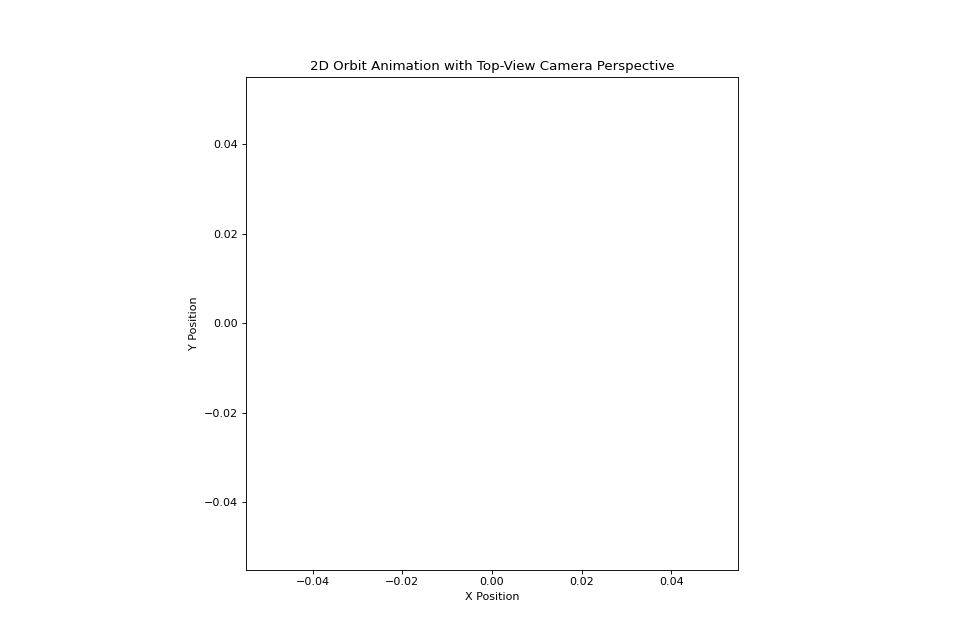

In [7]:
%matplotlib widget

# Create time array
time = t_vec

# Calculate object's position in the orbit
x_1, y_1 = dynamics['1_x_x'], dynamics['1_y_x']
x_2, y_2 = dynamics['2_x_x'], dynamics['2_y_x']
x_3, y_3 = dynamics['3_x_x'], dynamics['3_y_x']

b_x = np.average(np.column_stack((dynamics['1_x_x'], dynamics['2_x_x'], dynamics['3_x_x'])), axis=1)
b_y = np.average(np.column_stack((dynamics['1_y_x'], dynamics['2_y_x'], dynamics['3_y_x'])), axis=1)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)

# Plot the orbit and object
barycentre, = ax.plot([], [], 'ko', label='barycentre')

sc1_track, = ax.plot([], [], 'r--', label='sc1_track')
sc1,       = ax.plot([], [],  'ro', label='sc1')

sc2_track, = ax.plot([], [], 'b--', label='sc2_track')
sc2,       = ax.plot([], [],  'bo', label='sc2')

sc3_track, = ax.plot([], [], 'g--', label='sc3_track')
sc3,       = ax.plot([], [],  'go', label='sc3')

link_12,   = ax.plot([], [], 'k--', label='link_12')
link_13,   = ax.plot([], [], 'k--', label='link_13')
link_23,   = ax.plot([], [], 'k--', label='link_23')

# Set up the camera perspective
def init():
    sc1_track.set_data([], [])
    sc1.set_data([], [])

    sc2_track.set_data([], [])
    sc2.set_data([], [])

    sc3_track.set_data([], [])
    sc3.set_data([], [])

    link_12.set_data([], [])
    link_13.set_data([], [])
    link_23.set_data([], [])

    barycentre.set_data([], [])

    return sc1_track, sc1, sc2_track, sc2, sc3_track, sc3, link_12, link_13, link_23, barycentre,

def update(frame):
    barycentre_x, barycentre_y = b_x[frame], b_y[frame]

    sc1_track_x, sc1_track_y = x_1[:frame+1], y_1[:frame+1]
    sc2_track_x, sc2_track_y = x_2[:frame+1], y_2[:frame+1]
    sc3_track_x, sc3_track_y = x_3[:frame+1], y_3[:frame+1]

    sc1_x, sc1_y = x_1[frame], y_1[frame]
    sc2_x, sc2_y = x_2[frame], y_2[frame]
    sc3_x, sc3_y = x_3[frame], y_3[frame]

    barycentre.set_data(barycentre_x, barycentre_y)

    sc1_track.set_data(sc1_track_x, sc1_track_y)
    sc2_track.set_data(sc2_track_x, sc2_track_y)
    sc3_track.set_data(sc3_track_x, sc3_track_y)

    sc1.set_data(sc1_x, sc1_y)
    sc2.set_data(sc2_x, sc2_y)
    sc3.set_data(sc3_x, sc3_y)

    link_12.set_data([sc1_x, sc2_x], [sc1_y, sc2_y])
    link_13.set_data([sc1_x, sc3_x], [sc1_y, sc3_y])
    link_23.set_data([sc2_x, sc3_x], [sc2_y, sc3_y])

    # this can be adjusted to either have the camera follow the spacecraft
    # or to have the perspective be the entire constellation
    ax.set_xlim(barycentre_x - 2e6, barycentre_x + 2e6)
    ax.set_ylim(barycentre_y - 2e6, barycentre_y + 2e6)
    
    return sc1_track, sc1, sc2_track, sc2, sc3_track, sc3, link_12, link_13, link_23, barycentre,

# Create the animation
ani = FuncAnimation(fig, 
                    update, 
                    frames=len(time), 
                    init_func=init, 
                    blit=True,
                    repeat=False)

# ani.save('2D_Orbit.gif', writer='Pillow', fps=60)

# plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Orbit Animation with Top-View Camera Perspective')
plt.gca().set_aspect('equal', adjustable='box')
plt.show(block=False)

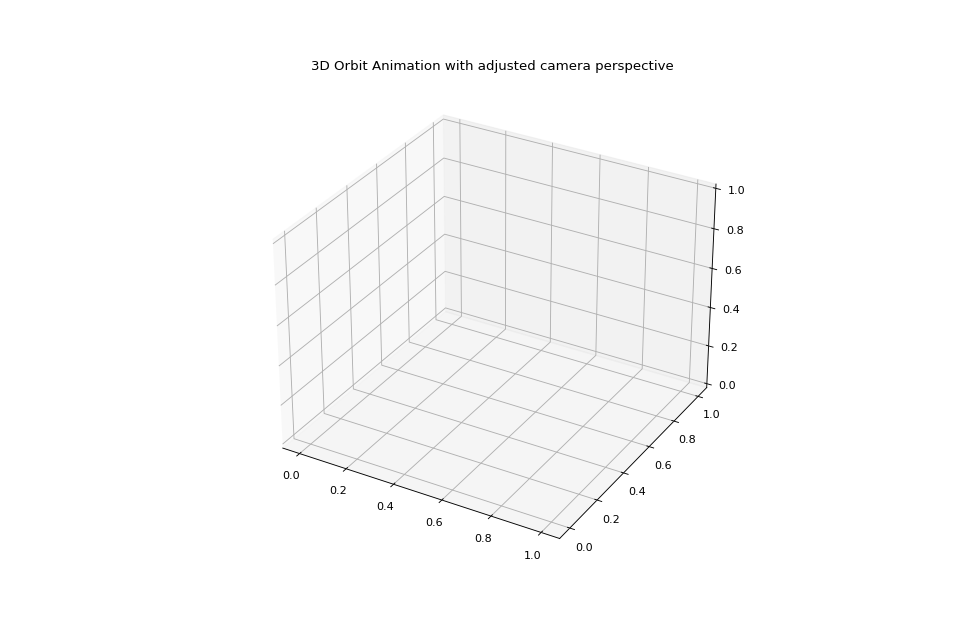

In [63]:
%matplotlib widget
fig = plt.figure(figsize=(12, 8), dpi=80)

# Create time array
time = t_vec

# Calculate object's position in the orbit
x_1, y_1, z_1 = dynamics['1_x_x'], dynamics['1_y_x'], dynamics['1_z_x']
x_2, y_2, z_2 = dynamics['2_x_x'], dynamics['2_y_x'], dynamics['2_z_x']
x_3, y_3, z_3 = dynamics['3_x_x'], dynamics['3_y_x'], dynamics['3_z_x']

b_x = np.average(np.column_stack((dynamics['1_x_x'], dynamics['2_x_x'], dynamics['3_x_x'])), axis=1)
b_y = np.average(np.column_stack((dynamics['1_y_x'], dynamics['2_y_x'], dynamics['3_y_x'])), axis=1)
b_z = np.average(np.column_stack((dynamics['1_z_x'], dynamics['2_z_x'], dynamics['3_z_x'])), axis=1)

def update(num):
    ax.view_init(elev=30, azim=30 + num * .5)

    ax.set_xlim(x_1[num] - 5e6, x_1[num] + 5e6)
    ax.set_ylim(y_1[num] - 5e6, y_1[num] + 5e6)
    ax.set_zlim(z_1[num] - 1e6, z_1[num] + 1e6)
    
    barycentre.set_xdata(b_x[num:num+1])
    barycentre.set_ydata(b_y[num:num+1])
    barycentre.set_3d_properties(b_z[num:num+1])
    
    sc1_track.set_xdata(x_1[0:num+1])
    sc1_track.set_ydata(y_1[0:num+1])
    sc1_track.set_3d_properties(z_1[0:num+1])

    sc2_track.set_xdata(x_2[0:num+1])
    sc2_track.set_ydata(y_2[0:num+1])
    sc2_track.set_3d_properties(z_2[0:num+1])

    sc3_track.set_xdata(x_3[0:num+1])
    sc3_track.set_ydata(y_3[0:num+1])
    sc3_track.set_3d_properties(z_3[0:num+1])

    sc1.set_xdata(x_1[num:num+1])
    sc1.set_ydata(y_1[num:num+1])
    sc1.set_3d_properties(z_1[num:num+1])

    sc2.set_xdata(x_2[num:num+1])
    sc2.set_ydata(y_2[num:num+1])
    sc2.set_3d_properties(z_2[num:num+1])
    
    sc3.set_xdata(x_3[num:num+1])
    sc3.set_ydata(y_3[num:num+1])
    sc3.set_3d_properties(z_3[num:num+1])

    link_12.set_xdata([x_1[num], x_2[num]])
    link_12.set_ydata([y_1[num], y_2[num]])
    link_12.set_3d_properties([z_1[num], z_2[num]])
    link_13.set_xdata([x_1[num], x_3[num]])
    link_13.set_ydata([y_1[num], y_3[num]])
    link_13.set_3d_properties([z_1[num], z_3[num]])
    link_23.set_xdata([x_2[num], x_3[num]])
    link_23.set_ydata([y_2[num], y_3[num]])
    link_23.set_3d_properties([z_2[num], z_3[num]])

    return barycentre, sc1_track, sc1, sc2_track, sc2, sc3_track, sc3, link_12, link_13, link_23

# Plot the orbit and object
ax  = fig.add_subplot(111, projection='3d')
barycentre, = ax.plot([], [], [], 'ko', label='barycentre')

sc1_track,  = ax.plot([], [], [], 'r--', label='sc1_track')
sc1,        = ax.plot([], [], [],  'ro', label='sc1')

sc2_track,  = ax.plot([], [], [], 'b--', label='sc2_track')
sc2,        = ax.plot([], [], [],  'bo', label='sc2')

sc3_track,  = ax.plot([], [], [], 'g--', label='sc3_track')
sc3,        = ax.plot([], [], [],  'go', label='sc3')

link_12,    = ax.plot([], [], [], 'k--', label='link_12')
link_13,    = ax.plot([], [], [], 'k--', label='link_13')
link_23,    = ax.plot([], [], [], 'k--', label='link_23')

# Create the animation
ani = FuncAnimation(fig, 
                    update, 
                    frames=len(time), 
                    blit=True,
                    repeat=False)

# plt.legend()
# ani.save('3D_Orbit.gif', writer='Pillow', fps=60)
plt.title('3D Orbit Animation with adjusted camera perspective')
# plt.axis('equal') look online for 3d equal axis using Axes3D module
plt.show()

In [9]:
x_1, y_1, z_1 = dynamics['1_x_x'], dynamics['1_y_x'], dynamics['1_z_x']
x_2, y_2, z_2 = dynamics['2_x_x'], dynamics['2_y_x'], dynamics['2_z_x']
x_3, y_3, z_3 = dynamics['3_x_x'], dynamics['3_y_x'], dynamics['3_z_x']

b_x = np.average(np.column_stack((dynamics['1_x_x'], dynamics['2_x_x'], dynamics['3_x_x'])), axis=1)
b_y = np.average(np.column_stack((dynamics['1_y_x'], dynamics['2_y_x'], dynamics['3_y_x'])), axis=1)
b_z = np.average(np.column_stack((dynamics['1_z_x'], dynamics['2_z_x'], dynamics['3_z_x'])), axis=1)

r_1, r_2, r_3 = np.column_stack((x_1, y_1, z_1)), np.column_stack((x_2, y_2, z_2)), np.column_stack((x_3, y_3, z_3))
b = np.column_stack((b_x, b_y, b_z))

In [10]:
x_1, y_1, z_1 = dynamics['1_x_x'], dynamics['1_y_x'], dynamics['1_z_x']
x_2, y_2, z_2 = dynamics['2_x_x'], dynamics['2_y_x'], dynamics['2_z_x']
x_3, y_3, z_3 = dynamics['3_x_x'], dynamics['3_y_x'], dynamics['3_z_x']

b_x = np.average(np.column_stack((dynamics['1_x_x'], dynamics['2_x_x'], dynamics['3_x_x'])), axis=1)
b_y = np.average(np.column_stack((dynamics['1_y_x'], dynamics['2_y_x'], dynamics['3_y_x'])), axis=1)
b_z = np.average(np.column_stack((dynamics['1_z_x'], dynamics['2_z_x'], dynamics['3_z_x'])), axis=1)

r_1, r_2, r_3 = np.column_stack((x_1, y_1, z_1)), np.column_stack((x_2, y_2, z_2)), np.column_stack((x_3, y_3, z_3))
b = np.column_stack((b_x, b_y, b_z))

sc1_inertial_x = (b - r_1)/np.linalg.norm(b - r_1)
sc2_inertial_x = (b - r_2)/np.linalg.norm(b - r_2)
sc3_inertial_x = (b - r_3)/np.linalg.norm(b - r_3)

sc_inertial_z = np.tile(np.array([0, 0, 1]).reshape(3, 1), (1, 1000))

# Initialize arrays to store the y-unit vectors for each time step
sc1_inertial_y = np.zeros((3, 1000))
sc2_inertial_y = np.zeros((3, 1000))
sc3_inertial_y = np.zeros((3, 1000))

# Compute the cross product for each time step
for i in range(1000):
    sc1_inertial_y[:, i] = np.cross(sc_inertial_z[:, i], sc1_inertial_x[i, :])
    sc2_inertial_y[:, i] = np.cross(sc_inertial_z[:, i], sc2_inertial_x[i, :])
    sc3_inertial_y[:, i] = np.cross(sc_inertial_z[:, i], sc3_inertial_x[i, :])

In [11]:
sc1_inertial_x[0, :], sc1_inertial_y[:, 0], sc_inertial_z[:, 0]

(array([ 1.58302018e-02, -5.57037842e-16,  2.74526315e-02]),
 array([ 5.57037842e-16,  1.58302018e-02, -0.00000000e+00]),
 array([0, 0, 1]))

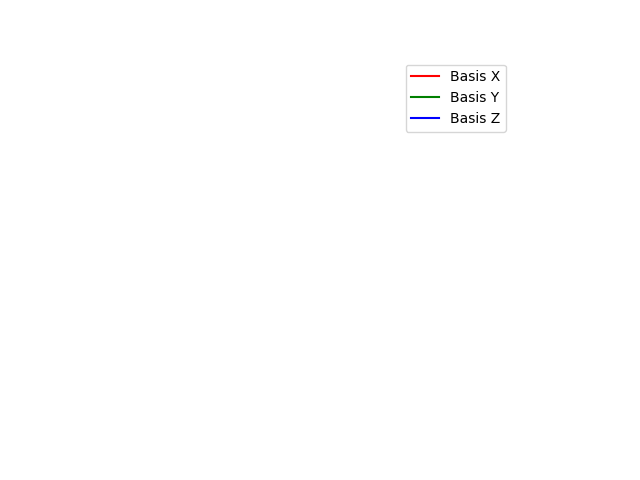

In [23]:
%matplotlib widget
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Set axis limits
ax.set_xlim([-1/20, 1/20])
ax.set_ylim([-1/20, 1/20])
ax.set_zlim([-1/20, 1/20])

# Initialize basis vectors
basis_x, = ax.plot([], [], [], 'r', label='Basis X')
basis_y, = ax.plot([], [], [], 'g', label='Basis Y')
basis_z, = ax.plot([], [], [], 'b', label='Basis Z')

ax.legend()

# Update function for animation
def update(frame):
    basis_x.set_xdata([0, sc1_inertial_x[frame, 0]])
    basis_x.set_ydata([0, sc1_inertial_x[frame, 1]])
    basis_x.set_3d_properties([0, sc1_inertial_x[frame, 2]])
    
    basis_y.set_xdata([0, sc1_inertial_y[0, frame]])
    basis_y.set_ydata([0, sc1_inertial_y[1, frame]])
    basis_y.set_3d_properties([0, sc1_inertial_y[2, frame]])
    
    basis_z.set_xdata([0, sc_inertial_z[0, frame]/20])
    basis_z.set_ydata([0, sc_inertial_z[1, frame]/20])
    basis_z.set_3d_properties([0, sc_inertial_z[2, frame]/20])
    
    return basis_x, basis_y, basis_z

# Create animation
ani = FuncAnimation(fig, update, frames=range(1000), blit=True)
plt.axis('off')
plt.show()

# Experimentation

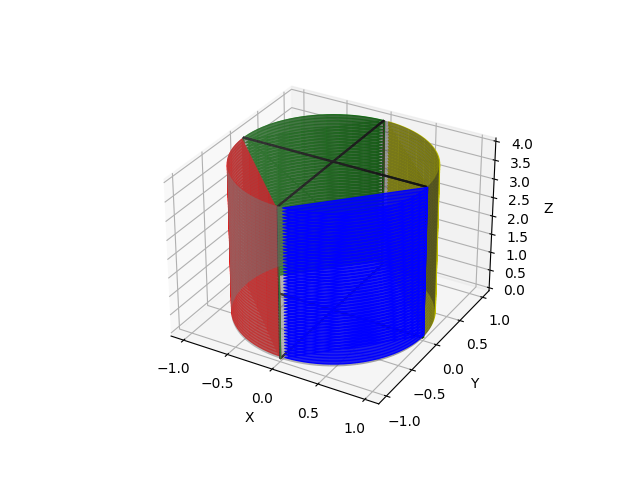

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

# Create cylinder parameters
radius = 1
height = 4

# Create a cylinder mesh
theta = np.linspace(0, 2 * np.pi, 100)
z = np.linspace(0, height, 50)
theta, z = np.meshgrid(theta, z)
x = radius * np.cos(theta)
y = radius * np.sin(theta)

# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create cylinder surface
cylinder = [list(zip(x_row, y_row, z_row)) for x_row, y_row, z_row in zip(x, y, z)]
cylinder = np.array(cylinder)

# Define quadrant boundaries
x_boundary = [-radius, 0, radius]
y_boundary = [-radius, 0, radius]

# Create quadrants manually and color them
quadrants = []
colors = ['r', 'g', 'b', 'y']

for i in range(2):
    for j in range(2):
        x_indices = (x_boundary[i] <= cylinder[:, :, 0]) & (cylinder[:, :, 0] <= x_boundary[i + 1])
        y_indices = (y_boundary[j] <= cylinder[:, :, 1]) & (cylinder[:, :, 1] <= y_boundary[j + 1])
        region_indices = np.logical_and(x_indices, y_indices)
        z_indices = cylinder[:, :, 2]
        indices = np.logical_and(region_indices, z_indices)
        quadrants.append(indices)

# Plot the cylinder surface with a neutral color
ax.plot_surface(x, y, z, color='gray', alpha=0.5)

# Create Poly3DCollection for each quadrant and assign colors
for i, indices in enumerate(quadrants):
    quadrant = cylinder[indices]
    poly = Poly3DCollection([quadrant], color=colors[i], alpha=0.8)
    ax.add_collection3d(poly)

# Create lines to represent the division on top face
top_lines = [
    [(0, 0, 0), (radius, 0, 0)],
    [(0, 0, 0), (0, radius, 0)],
    [(0, 0, height), (radius, 0, height)],
    [(0, 0, height), (0, radius, height)]
]

# Add lines for other quadrants
for line in top_lines:
    rotated_lines = []
    for i in range(4):
        angle = i * np.pi / 2
        rotated_line = [(x * np.cos(angle) - y * np.sin(angle),
                         x * np.sin(angle) + y * np.cos(angle),
                         z) for x, y, z in line]
        rotated_lines.append(rotated_line)
    line_collection = Line3DCollection(rotated_lines, color='black')
    ax.add_collection3d(line_collection)

# Create lines to connect the top and bottom faces
for i in range(4):
    top_point = (radius * np.cos(i * np.pi / 2), radius * np.sin(i * np.pi / 2), 0)
    bottom_point = (radius * np.cos(i * np.pi / 2), radius * np.sin(i * np.pi / 2), height)
    connecting_line = [(top_point, bottom_point)]
    connecting_line_collection = Line3DCollection(connecting_line, color='black')
    ax.add_collection3d(connecting_line_collection)

# Fill the regions between the lines with the corresponding colors
for i in range(4):
    top_point = (radius * np.cos(i * np.pi / 2), radius * np.sin(i * np.pi / 2), 0)
    bottom_point = (radius * np.cos(i * np.pi / 2), radius * np.sin(i * np.pi / 2), height)
    side_points = [(radius * np.cos(i * np.pi / 2), radius * np.sin(i * np.pi / 2), z) for z in [0, height]]
    fill_points_top = [top_point] + side_points + [top_point]
    fill_points_bottom = [bottom_point] + side_points + [bottom_point]
    fill_poly_top = Poly3DCollection([fill_points_top], color='red', alpha=0.8)
    fill_poly_bottom = Poly3DCollection([fill_points_bottom], color='green', alpha=0.8)
    ax.add_collection3d(fill_poly_top)
    ax.add_collection3d(fill_poly_bottom)

# Set plot labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


In [348]:
# Surface area of a cylinder
# A = 2 * pi * r * h + 2 * pi * r^2
# Everything is in meters
r = 2
h = 3
A_orig = 2 * np.pi * r * h + 2 * np.pi * r**2

# Total number of desired partitions for all parts
N = 8

# Number of desired radii
M = 2 

# The location we choose is dependent on angle and radius? I think this is the best way to do it
angpos_topbot = np.linspace(0, 360, int(N/M)+1) 
angpos_side   = np.linspace(0, 360, N+1)
radii = np.linspace(0, r, M+1) # will probably have to use j+1 for initialization in a for loop

Atopbot = np.zeros([2, len(angpos_topbot)-1, len(radii)-1])
for kk in range(2):
    for ii in range(len(angpos_topbot)-1):
        for jj in range(M):
            Atopbot[kk, ii, jj] = M/N * np.pi * (radii[jj+1]**2 - radii[jj]**2)

Aside = np.zeros([len(angpos_side)-1])      
for mm in range(len(angpos_side)-1):   
    Aside[mm] = (2/N) * np.pi * radii[-1] * h


A = np.sum(Atopbot) + np.sum(Aside)
print(A)
print(A_orig)
# np.prod(Atopbot.shape[:]) + np.prod(Aside.shape[:])

62.83185307179586
62.83185307179586


In [353]:
rn_kk = np.random.randint(0, 2)
rn_jj = np.random.randint(1, M+1)
rn_ii = np.random.randint(1, len(angpos_topbot)-1)
rn_mm = np.random.randint(1, len(angpos_side)-1) 

rn_topbotorside = np.random.randint(0, 2)

rn_ii, rn_jj, rn_kk, rn_mm, rn_topbotorside

if rn_topbotorside == 0: # top or bot face
    chosen_face = Atopbot[rn_kk, rn_ii, rn_jj-1]
    angular_position = angpos_topbot[rn_ii] - angpos_topbot[1]/2
    radius_position  = radii[rn_jj]
    center_x = radius_position * np.cos((np.pi/180)*angular_position)
    center_y = radius_position * np.sin((np.pi/180)*angular_position)
    if rn_kk == 0: # top face
        face = 'top'
        center_z = h/2
    else: # bottom face
        face = 'bot'
        center_z = -h/2
    print(f'Area = {chosen_face:.3f} [m^2]')
    print(f'Angle = {angular_position:.1f} [deg]')
    print(f'Radius = {radius_position:.1f} [m]')
    print(f'Face: {face}')
    print(f'Center of Surface Element from CM: ({center_x:.2f}, {center_y:.2f}, {center_z:.2f}) [m]')
    print(f'    Magnitude: {np.linalg.norm([center_x, center_y, center_z]):.2f} [m]')
else: # side face
    chosen_face = Aside[rn_mm]
    angular_position = angpos_side[rn_mm] - angpos_side[1]/2
    radius_position = radii[-1]
    face = 'side'
    center_x = radius_position * np.cos((np.pi/180)*angular_position)
    center_y = radius_position * np.sin((np.pi/180)*angular_position)
    center_z = 0
    print(f'Area = {chosen_face:.3f} [m^2]')
    print(f'Angle = {angular_position:.1f} [deg]')
    print(f'Radius = {radius_position:.1f} [m]')
    print(f'Face: {face}')
    print(f'Center of Surface Element from CM: ({center_x:.2f}, {center_y:.2f}, {center_z:.2f}) [m]')
    print(f'    Magnitude: {np.linalg.norm([center_x, center_y, center_z]):.2f} [m]')

Area = 2.356 [m^2]
Angle = 225.0 [deg]
Radius = 2.0 [m]
Face: bot
Center of Surface Element from CM: (-1.41, -1.41, -1.50) [m]
    Magnitude: 2.50 [m]
